### Advanced Lane Finding Project

Expected steps:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [45]:
# Import routine
import os, glob, time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Patch
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [46]:
def advlf_step_read_images(test_folder='test_images'):
    # Step 0 - Read test images
    images = glob.glob(test_folder+'/*.jpg')      
    test_images = list()
    for fname in images:
        img = mpimg.imread(fname)
        test_images.append(img)
    
    return test_images
     

In [47]:
test_images = advlf_step_read_images(test_folder='test_images')
print('Success! Read ', len(test_images), ' images')

Success! Read  8  images


In [48]:
# Step 1. Camera calibration

def calibrate_camera(calib_folder, save_result=False, destination_folder='output_images'):
    nx = 9
    ny = 6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(calib_folder+'/calibration*.jpg')      
    imshape = None
    out_img = None
    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        out_img = img
        imshape = img.shape
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)    
    
    if imshape is not None:
        if save_result:
            cv2.imwrite(os.path.join(destination_folder,'step1_chessboard.png'), cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))
    
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imshape[1::-1], None, None)
        return ret, mtx, dist, rvecs, tvecs
    else:
        print('Cannot find any image in given folder. Exiting')
        return None
    

In [49]:
def advlf_step_calibrate_camera(calib_folder='camera_cal'):
    # Step 1 - Camera Calibration
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(calib_folder, save_result=True)
    return ret, mtx, dist, rvecs, tvecs

In [50]:
ret, mtx, dist, rvecs, tvecs = advlf_step_calibrate_camera(calib_folder='camera_cal')
print('Calibration complete!')
print('Matrix : ', mtx)
print('Dist: ', dist)

Calibration complete!
Matrix :  [[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Dist:  [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259866]]


In [51]:
## Step 2. Distortion correction

def advlf_undistort(img, mtx, dist):
    
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist_image



In [52]:
def advlf_step_undistort(test_images, mtx, dist):
    undistorted_images = list()
    # Step 2 - Distortion correction
    for ind, image in enumerate(test_images):
        undistorted_images.append(advlf_undistort(image, mtx, dist))
        
    return undistorted_images

In [53]:
undistorted_images = advlf_step_undistort(test_images, mtx, dist)

In [54]:
# Gradient Threhsolding helper functions
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    param1=0
    param2=0
    if orient=='x':
        param1=1
        param2=0
    elif orient=='y':
        param1=0
        param2=1
    else:
        print('Invalid value in orient parameter. Choose \'x\' or \'y\'')
    # 3) Take the absolute value of the derivative or gradient
    sobel_orient = cv2.Sobel(gray, cv2.CV_64F, param1, param2, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel_orient)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel>=mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    sobel_binary = np.zeros_like(sobel_grad)
    sobel_binary[(sobel_grad>=thresh[0]) & (sobel_grad<=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sobel_binary

def red_channel_threshold(img, thresh=(200,255)):
    red_channel = img[:,:,0]
    binary = np.zeros_like(red_channel)
    binary[(red_channel > thresh[0]) & (red_channel <= thresh[1])] = 1
    
    return binary
    
def saturation_channel_threshold(img, thresh=(90,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    saturation_channel = hls[:,:,2]
    binary = np.zeros_like(saturation_channel)
    binary[(saturation_channel > thresh[0]) & (saturation_channel <= thresh[1])] = 1
    
    return binary

In [55]:
## Step 3. Gradient Binary Threshold

def advlf_gradient_threshold(img, plot_enabled=False):
    # Sobel kernel size
    ksize = 3 
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    red_channel_binary = red_channel_threshold(img, thresh=(230, 255))
    saturation_binary = saturation_channel_threshold(img, thresh=(170,255)) #90
    #selected_saturation = saturation_binary == 1

    #Mask init
    combined = np.zeros_like(dir_binary)
    color_mask = np.zeros_like(dir_binary)
    dirmag_combined = np.zeros_like(dir_binary)
    gradxgrady_combined = np.zeros_like(dir_binary)
    
    # Criteria application
    color_mask[saturation_binary==1] = 1
    dirmag_combined[(mag_binary==1) & (dir_binary==1)] = 1
    gradxgrady_combined[(gradx==1) & (grady==1)] = 1
    combined[(color_mask==1) | (gradxgrady_combined==1) | (dirmag_combined==1)] = 1
    
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    if plot_enabled:
        stacked_thresh = np.dstack((color_mask, dirmag_combined, gradxgrady_combined))
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))


        legend_elements = [Patch(facecolor='red', edgecolor='r',
                                 label='Saturation Threshold'),
                           Patch(facecolor='green', edgecolor='g',
                                 label='Direction+Magnitude'),
                           Patch(facecolor='blue', edgecolor='b',
                                 label='GradientX+GradientY')]

        # Create the figure

        f.tight_layout()
        ax1.set_title('Original Image', fontsize=24)
        ax2.set_title('Stacked thresholds', fontsize=24)
        ax2.legend(handles=legend_elements)
        ax3.set_title('Combined thresholds', fontsize=24)
        ax1.imshow(img)
        ax2.imshow(stacked_thresh)
        ax3.imshow(combined, cmap='gray')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        

    
    return combined

In [56]:
def advlf_step_gradient_threshold(test_images, plot_enabled):
    grad_thresh_images = list()

    # Step 3 - Gradient Thresholding
    for image in test_images:
        curr_grad_thresh = advlf_gradient_threshold(image, plot_enabled=plot_enabled)
        grad_thresh_images.append(curr_grad_thresh)
    
    return grad_thresh_images

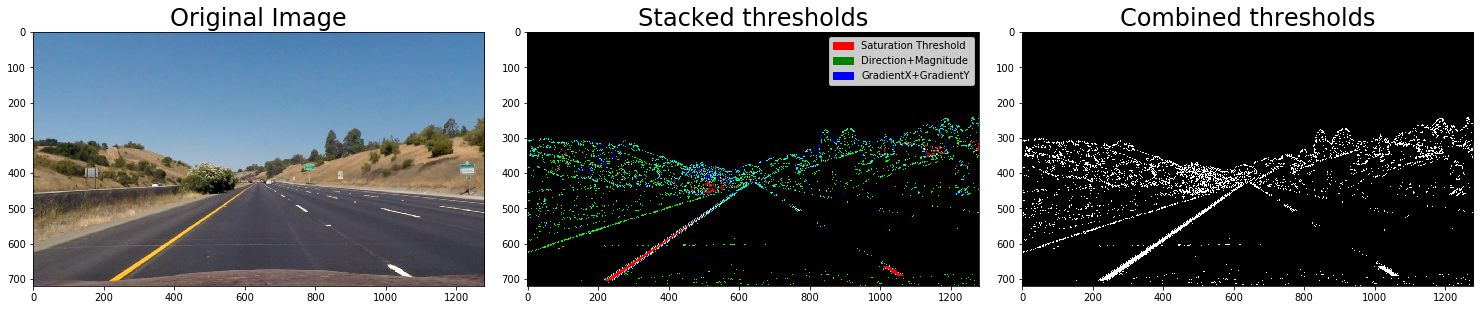

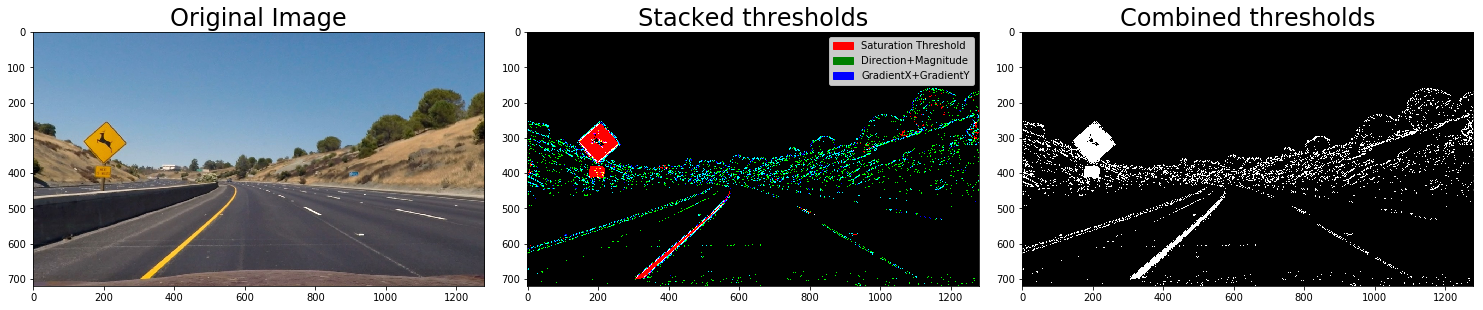

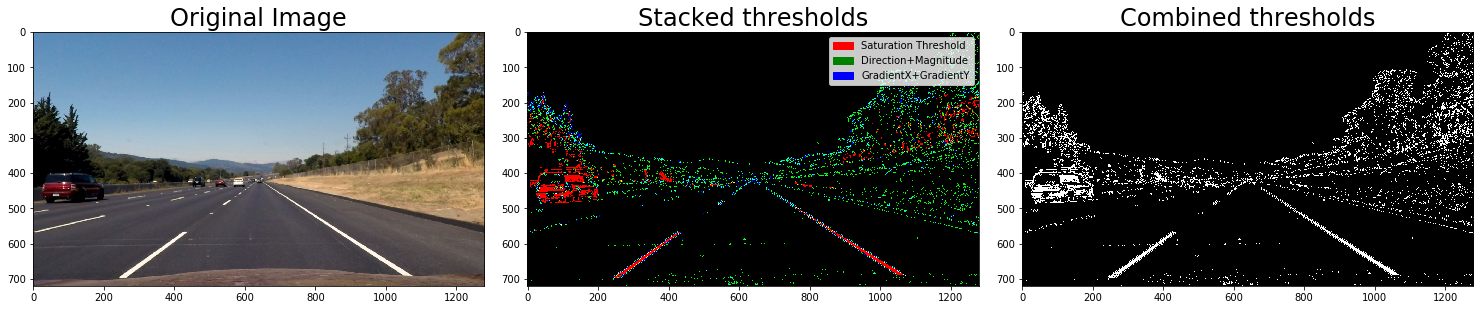

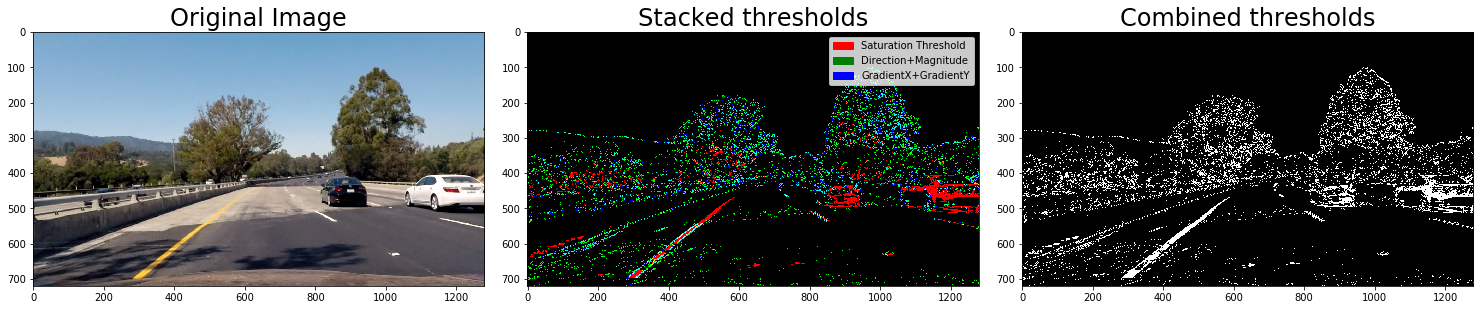

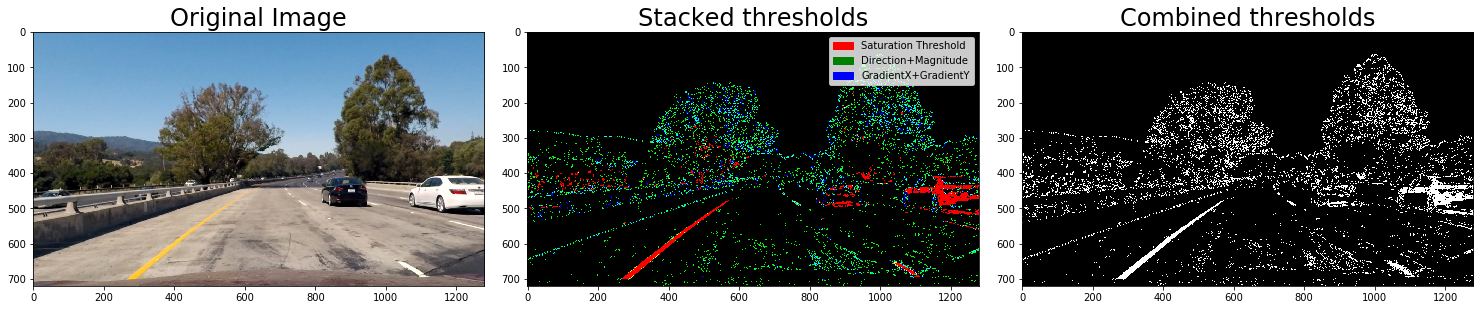

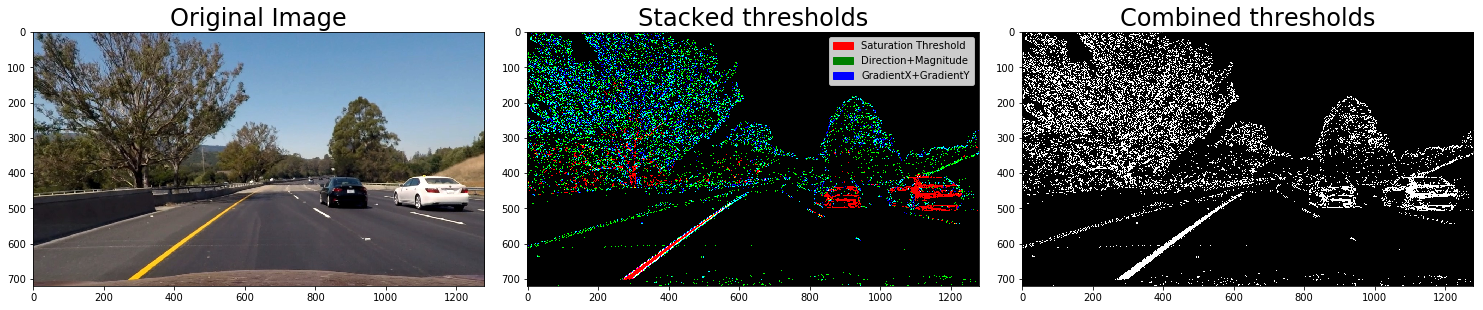

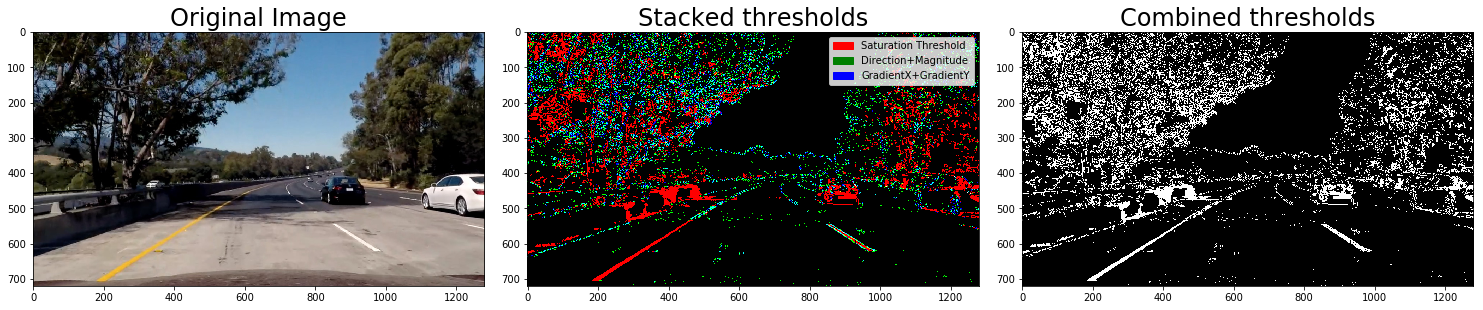

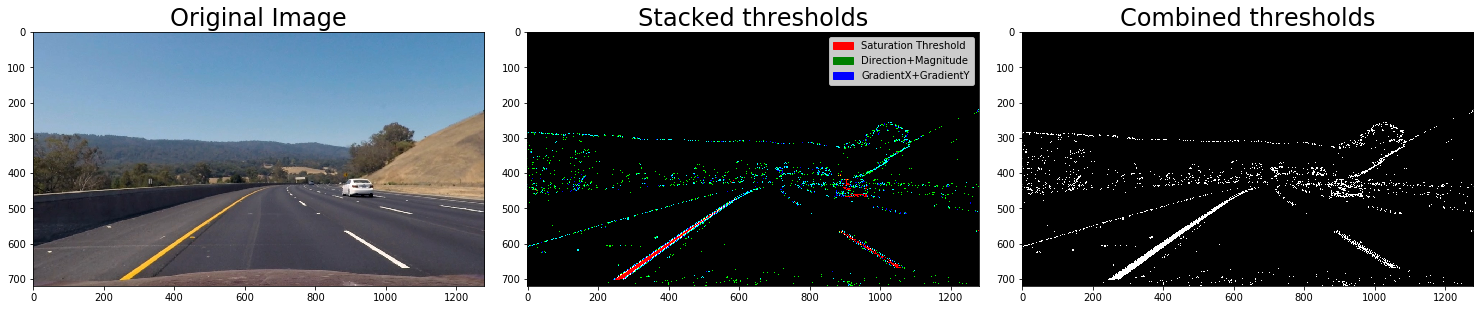

In [57]:
grad_thresh_images = advlf_step_gradient_threshold(undistorted_images, plot_enabled=True)

In [58]:
# Step 4 - Perspective Transform
def advlf_perspective_transform(img, roi, load_pickle=False):
    
    
    if load_pickle:
        src = pickle.load( open( os.path.join('perspectiveTransform', 'selected_coords.pickle'), "rb" ) )
    else:
        src = roi
    
    img_size = (img.shape[1], img.shape[0])
    
    offset = 100
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                 [img_size[0]-offset, img_size[1]], 
                                 [offset, img_size[1]]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M

In [59]:
def advlf_step_perspective_transform(test_images, perp_roi, plot_enabled=False):
    perp_trans_images = list()
    perp_matrices = list()
    # Step 4 - Perspective Transform
    for image in test_images:
        curr_warped, curr_M = advlf_perspective_transform(image, perp_roi)
        perp_trans_images.append(curr_warped)
        perp_matrices.append(curr_M)
        
        if plot_enabled:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(image)
            ax1.set_title('Original Image', fontsize=50)
            ax2.imshow(curr_warped)
            ax2.set_title('Undistorted and Warped Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


    return perp_trans_images, perp_matrices

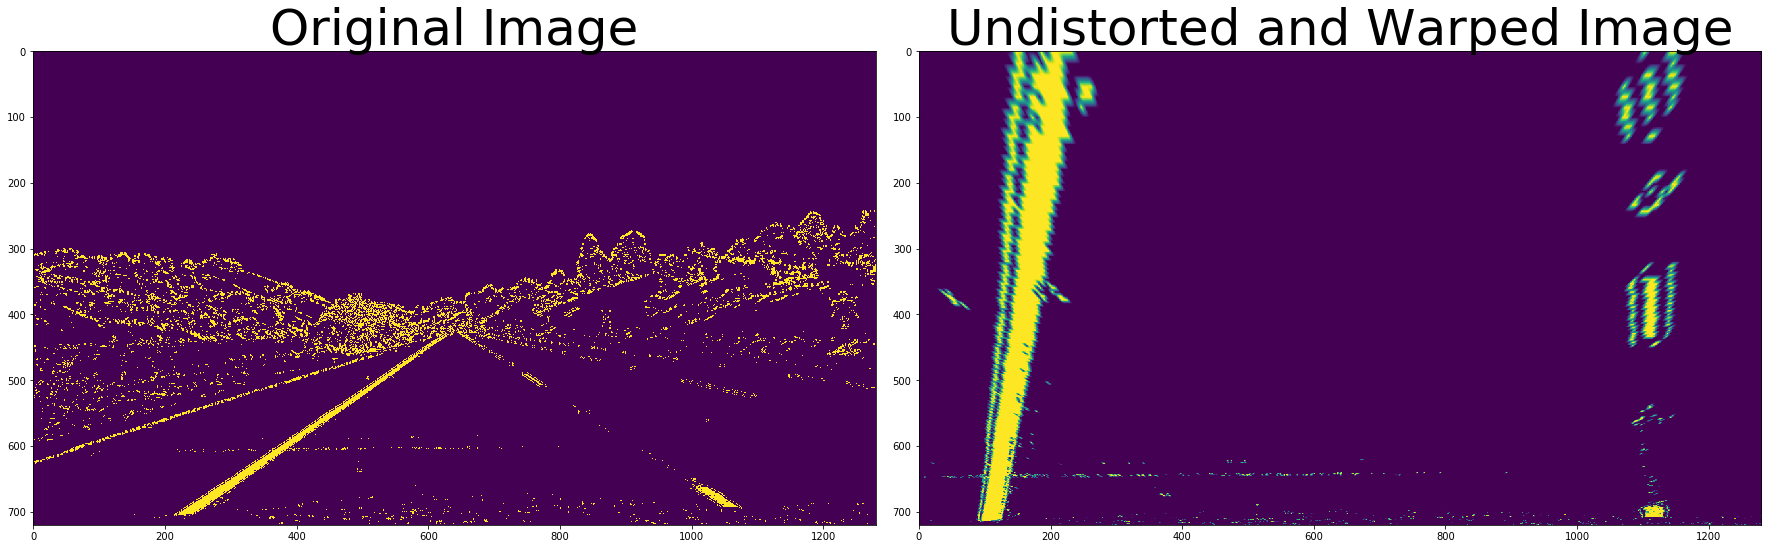

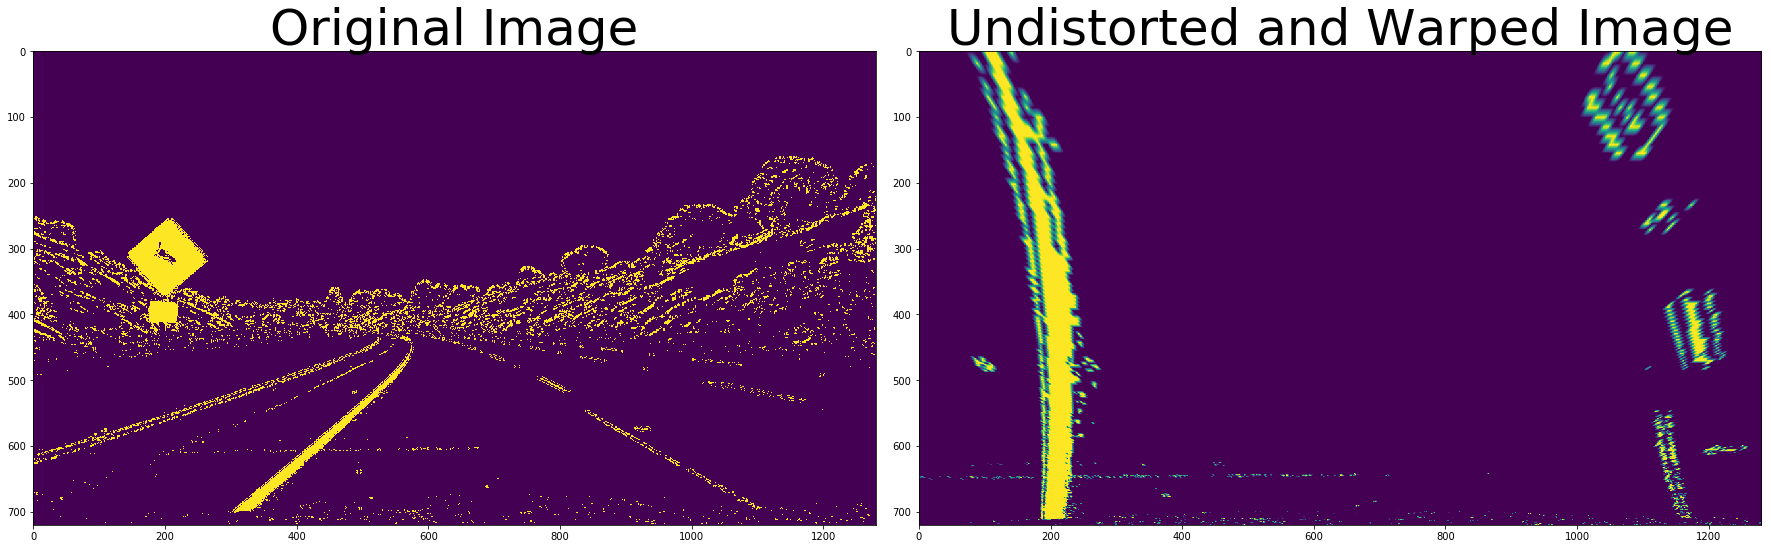

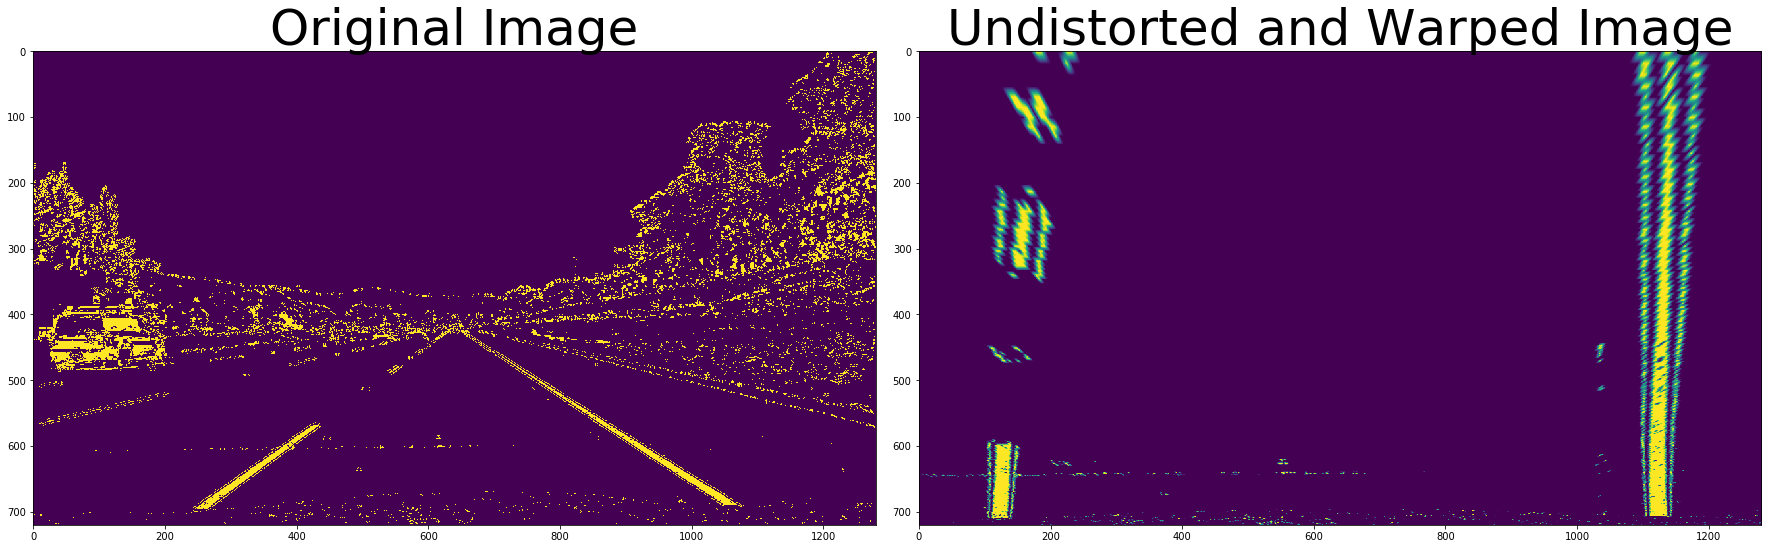

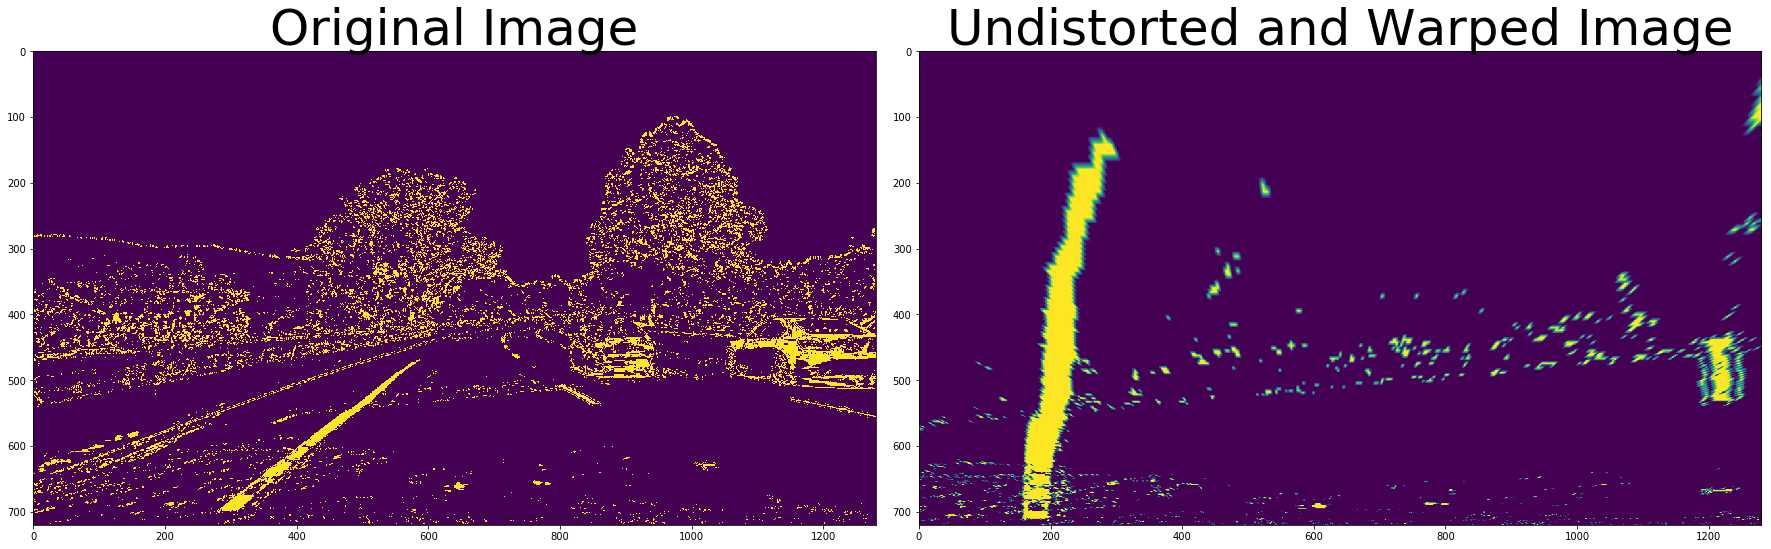

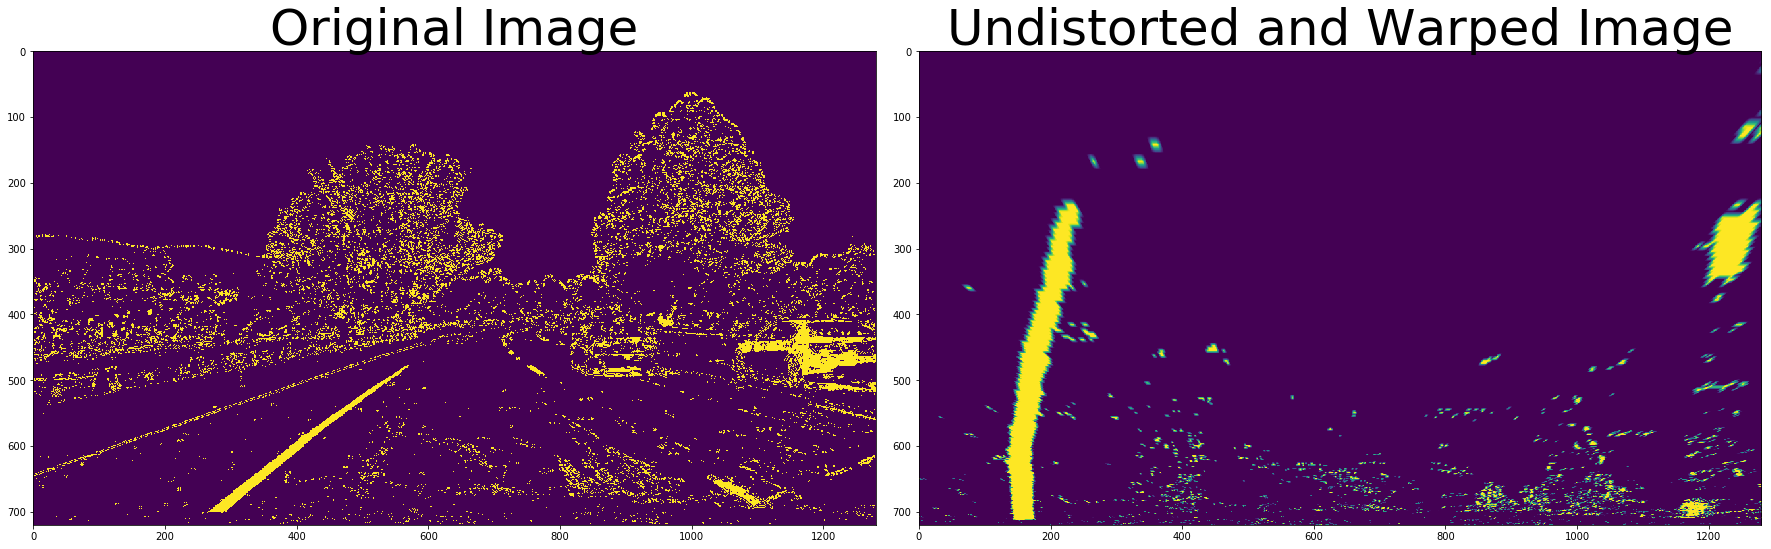

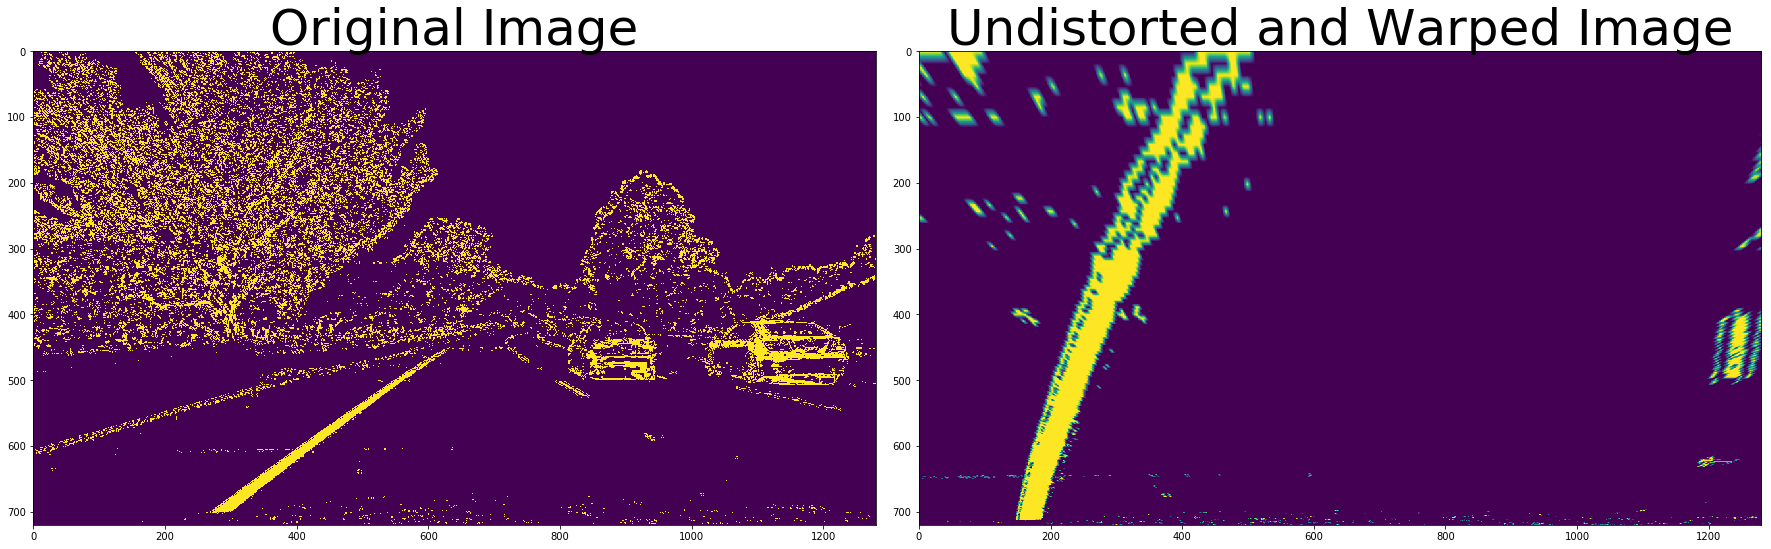

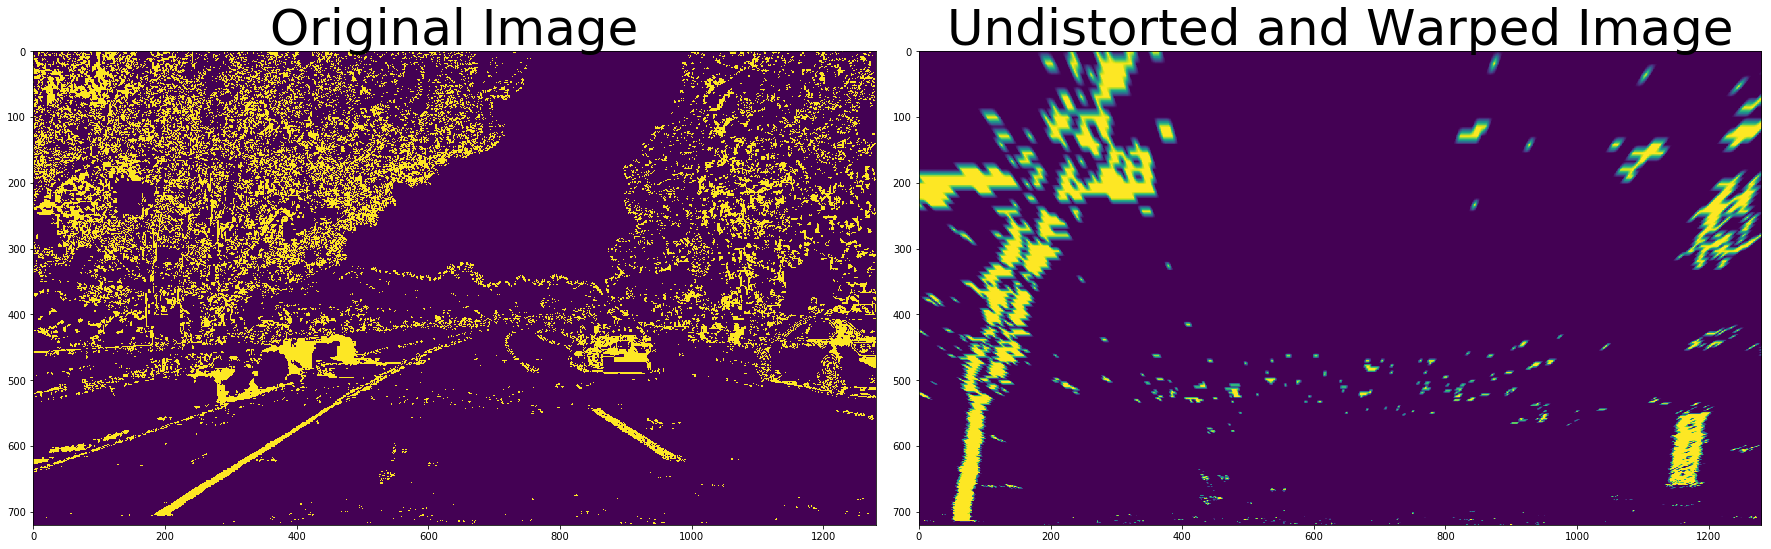

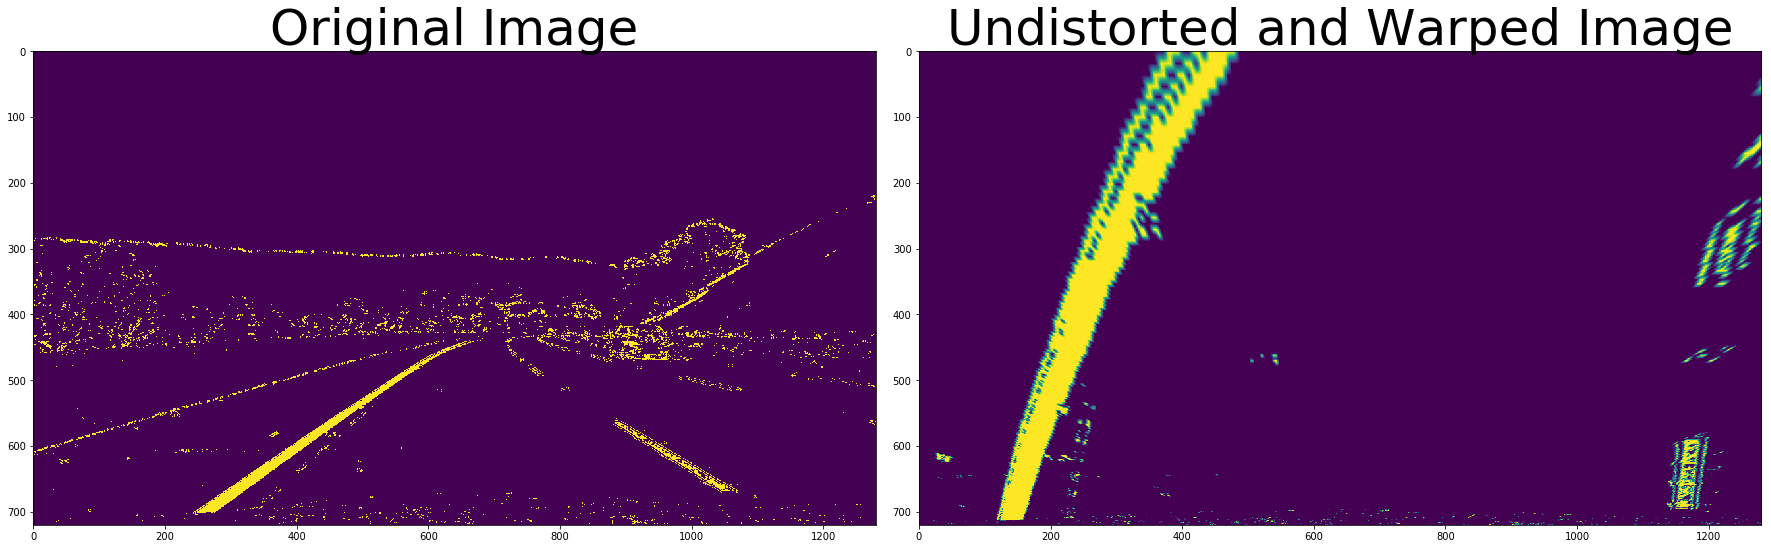

In [60]:
ROI_Y_MIN = 460
ROI_Y_MAX = 720

perp_roi = np.float32([(570,ROI_Y_MIN),(710, ROI_Y_MIN),(1160, ROI_Y_MAX),(200, ROI_Y_MAX)])

warped_images, perp_matrices = advlf_step_perspective_transform(grad_thresh_images, perp_roi, plot_enabled=True)

In [61]:
# Line class definition
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #polynomial coefficients for the previous fit
        self.prev_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x pixel to meter conversion factor
        self.xm_per_pix = None
        #y pixel to meter conversion factor
        self.ym_per_pix = None
    
    def measure_real_curvature(self, roi):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        MAX_LONG_LENGTH = 30
        MAX_LAT_LENGTH = 3.7
        PERP_TRANS_LONG_PIXELS = 720 # longitudinal result of perp transform
        PERP_TRANS_LAT_PIXELS = 960 # is 1160-200 from perp trans parameters

        roi_x_size = roi[2][0] - roi[3][0]
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = MAX_LONG_LENGTH/PERP_TRANS_LONG_PIXELS #  meters per pixel in y dimension
        self.xm_per_pix = MAX_LAT_LENGTH/roi_x_size #  meters per pixel in x dimension
        
        # Fit in real space
        fit_cr = np.polyfit(self.allx*self.ym_per_pix, self.ally*self.xm_per_pix, 2)
        y_eval=np.max(self.allx)
    
        curvature = ((1 + (2*fit_cr[0]*y_eval*self.ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
        self.radius_of_curvature = curvature

   

In [62]:
# Step 5 - Find lane boundaries
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),color=(0,255,0), thickness=2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),color=(0,255,0), thickness=2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return histogram, leftx, lefty, rightx, righty, out_img

In [63]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_line, right_line, plot_enabled=False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = np.copy(left_line.prev_fit)
    right_fit = np.copy(right_line.prev_fit)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    if plot_enabled:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return leftx, lefty, rightx, righty, result


In [64]:
def advlf_lane_boundaries_fit_polynomial(binary_warped, left_line, right_line, roi, 
                                         look_ahead_enabled=False, plot_enabled=False):
    
    if look_ahead_enabled:
        leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped, left_line, right_line)
        histogram = np.zeros_like(out_img)
    else:
        histogram, leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    if plot_enabled:
        plt.plot(left_fitx, ploty, color='yellow', linewidth=8)
        plt.plot(right_fitx, ploty, color='yellow', linewidth=8)
    
    # Line objects population
    left_line.allx = ploty
    left_line.ally = left_fitx
    left_line.current_fit = np.copy(left_fit)
    left_line.measure_real_curvature(roi)
    
    right_line.allx = ploty
    right_line.ally = right_fitx
    right_line.current_fit = np.copy(right_fit)
    right_line.measure_real_curvature(roi)
    
    
    return histogram, out_img

In [65]:
# Step 5 - Find lane lines
    
def advlf_step_find_lane_lines(test_images, plot_enabled=False):
    
    left_lines_detected = list()
    right_lines_detected = list()
    binary_detected_list = list()
    
    for image in test_images:
        
        detected_left_line = Line()
        detected_right_line = Line()
        
        if plot_enabled:
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(50, 10))
        
        histogram, out_img = advlf_lane_boundaries_fit_polynomial(image, detected_left_line, detected_right_line, perp_roi)
        
        if plot_enabled:
            f.tight_layout()
            ax1.imshow(image)
            ax1.set_title('Perspective Trans Image', fontsize=50)
            ax2.plot(histogram)
            ax2.set_title('Histogram', fontsize=50)
            ax3.imshow(out_img)
            ax3.set_title('Lane detected', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., wspace=0.1)

        
        left_lines_detected.append(detected_left_line)
        right_lines_detected.append(detected_right_line)
        binary_detected_list.append(out_img)
        
    return binary_detected_list, left_lines_detected, right_lines_detected
     

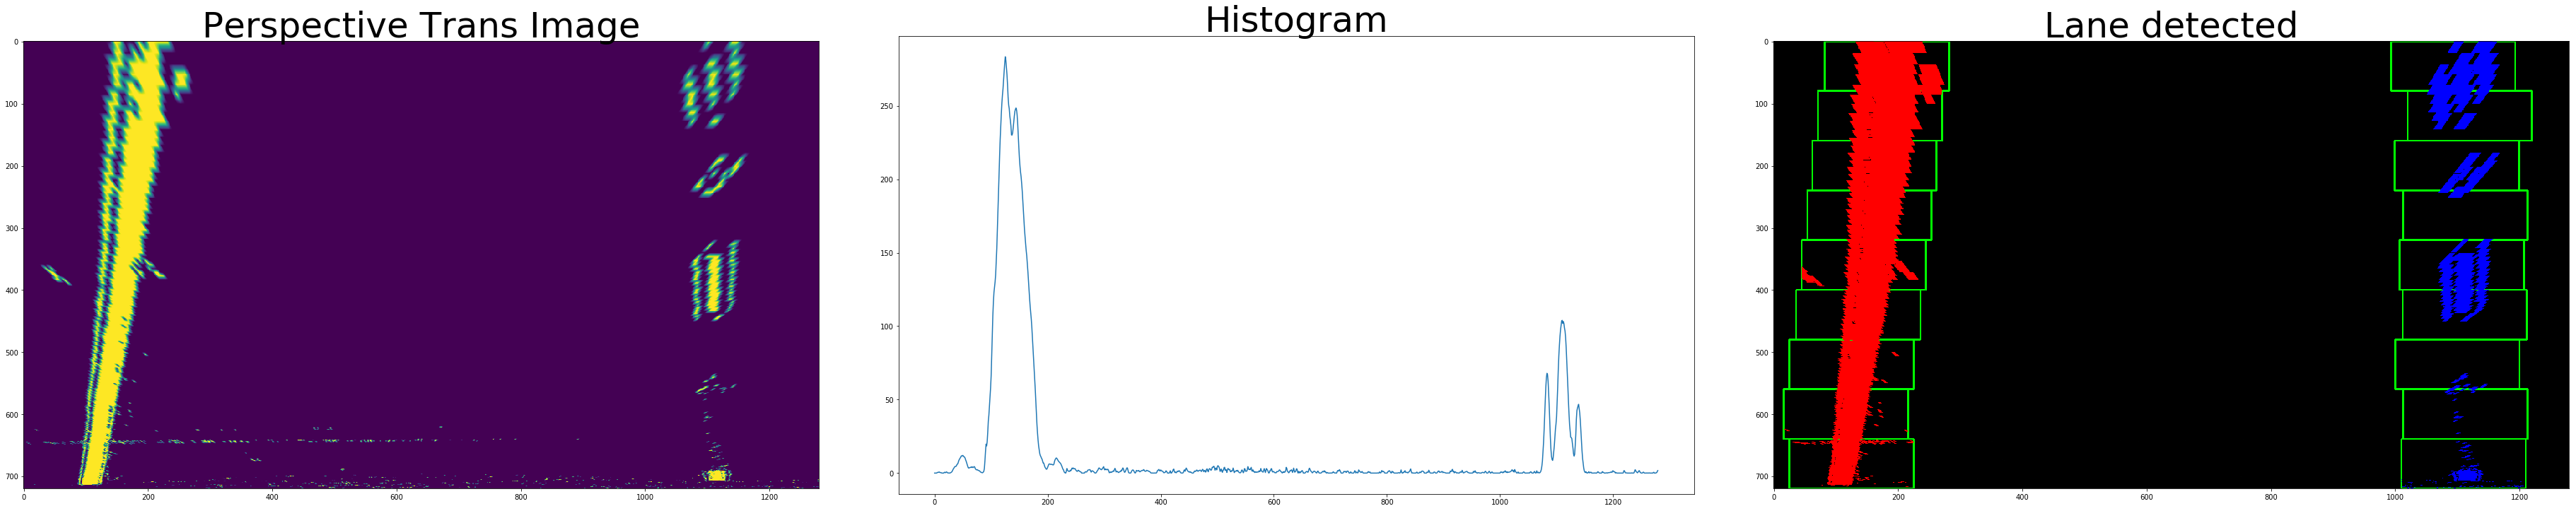

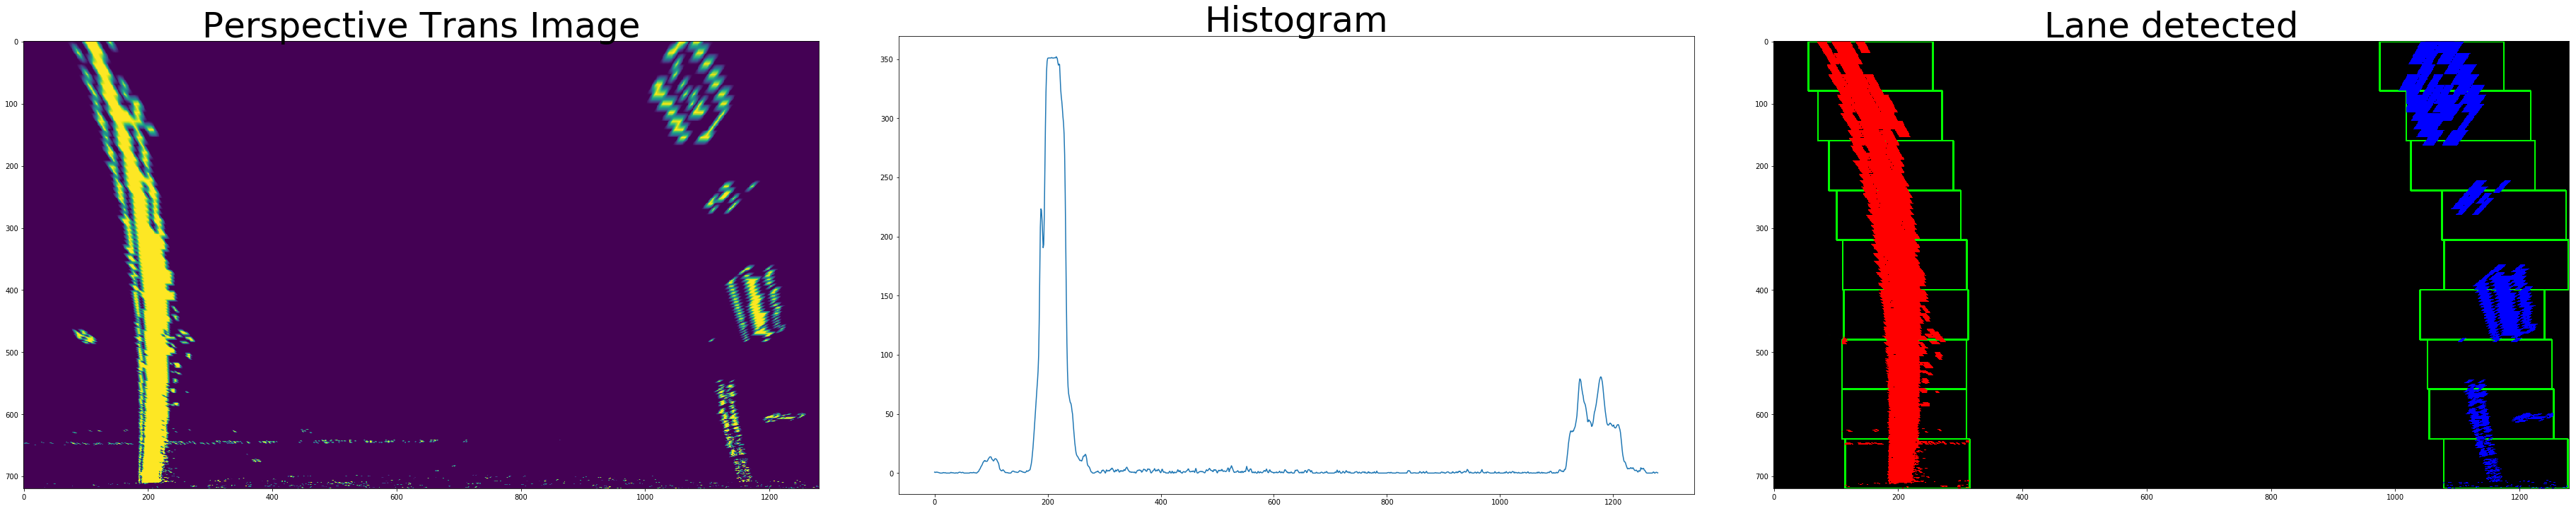

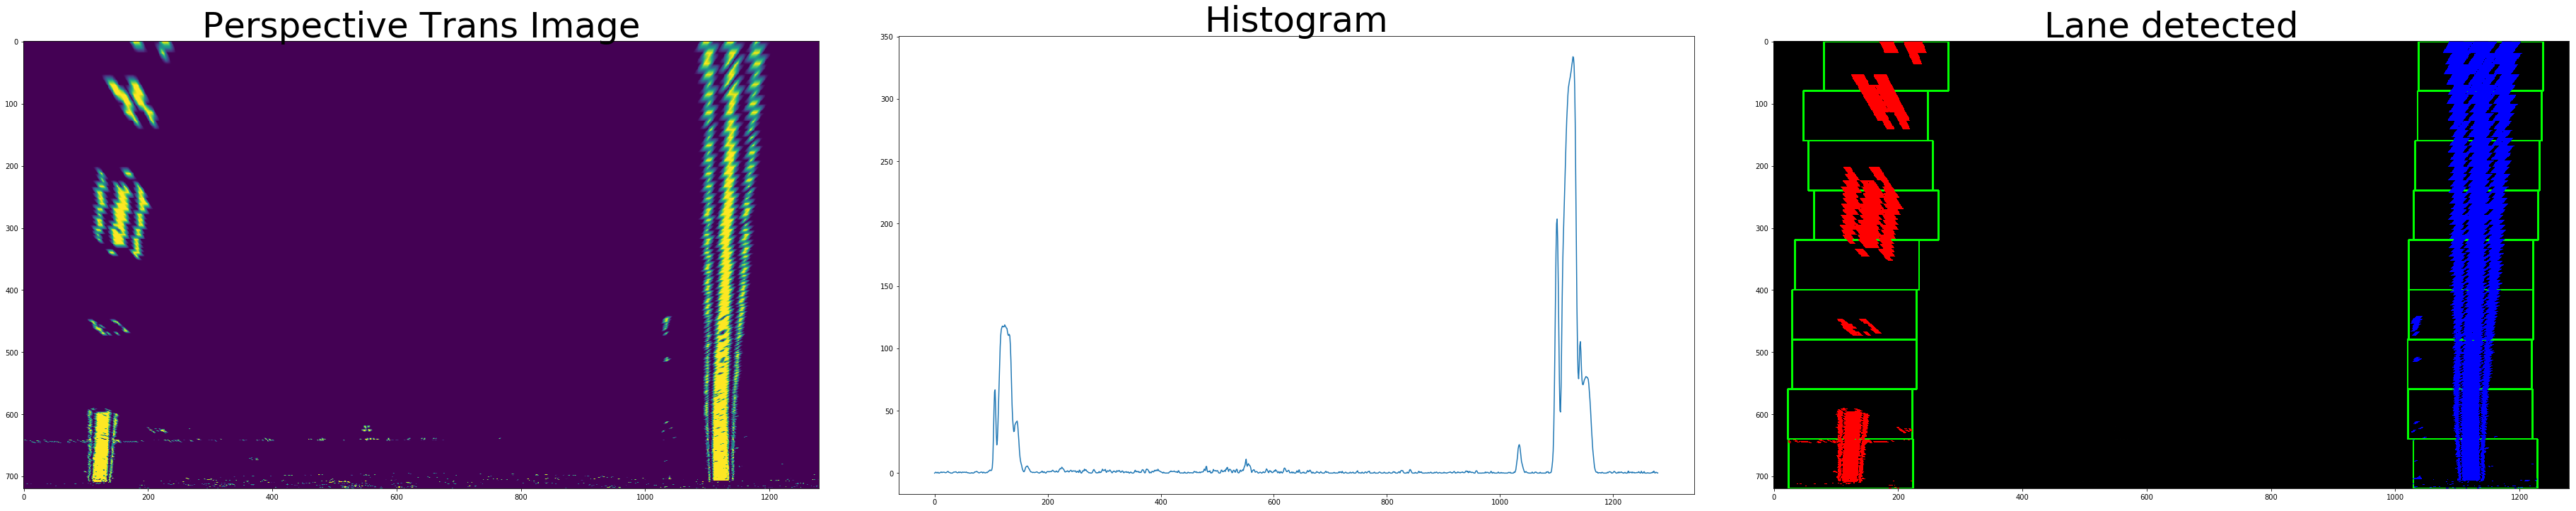

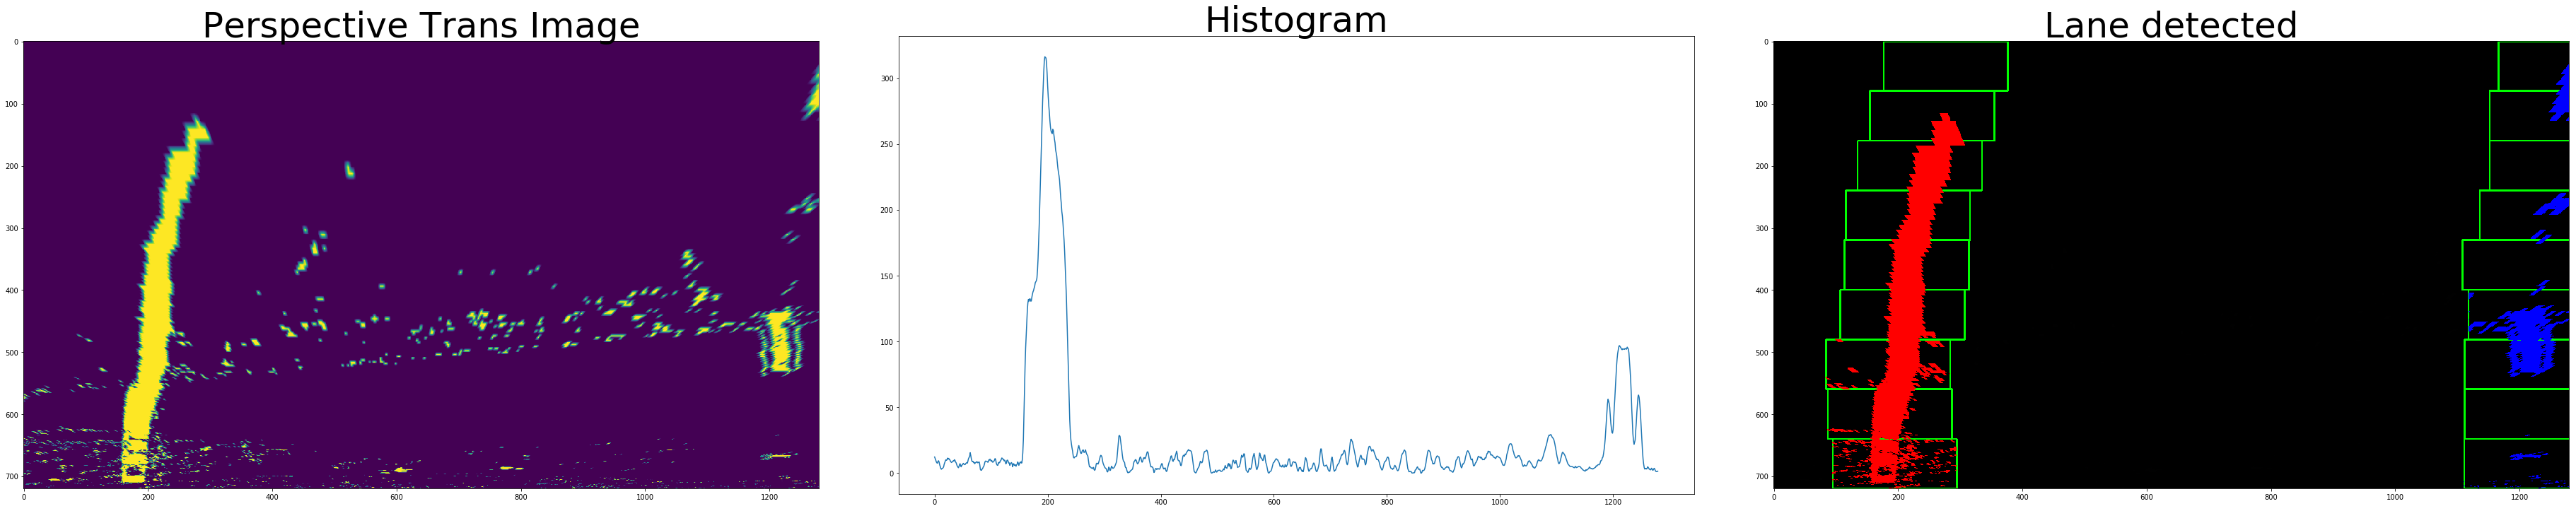

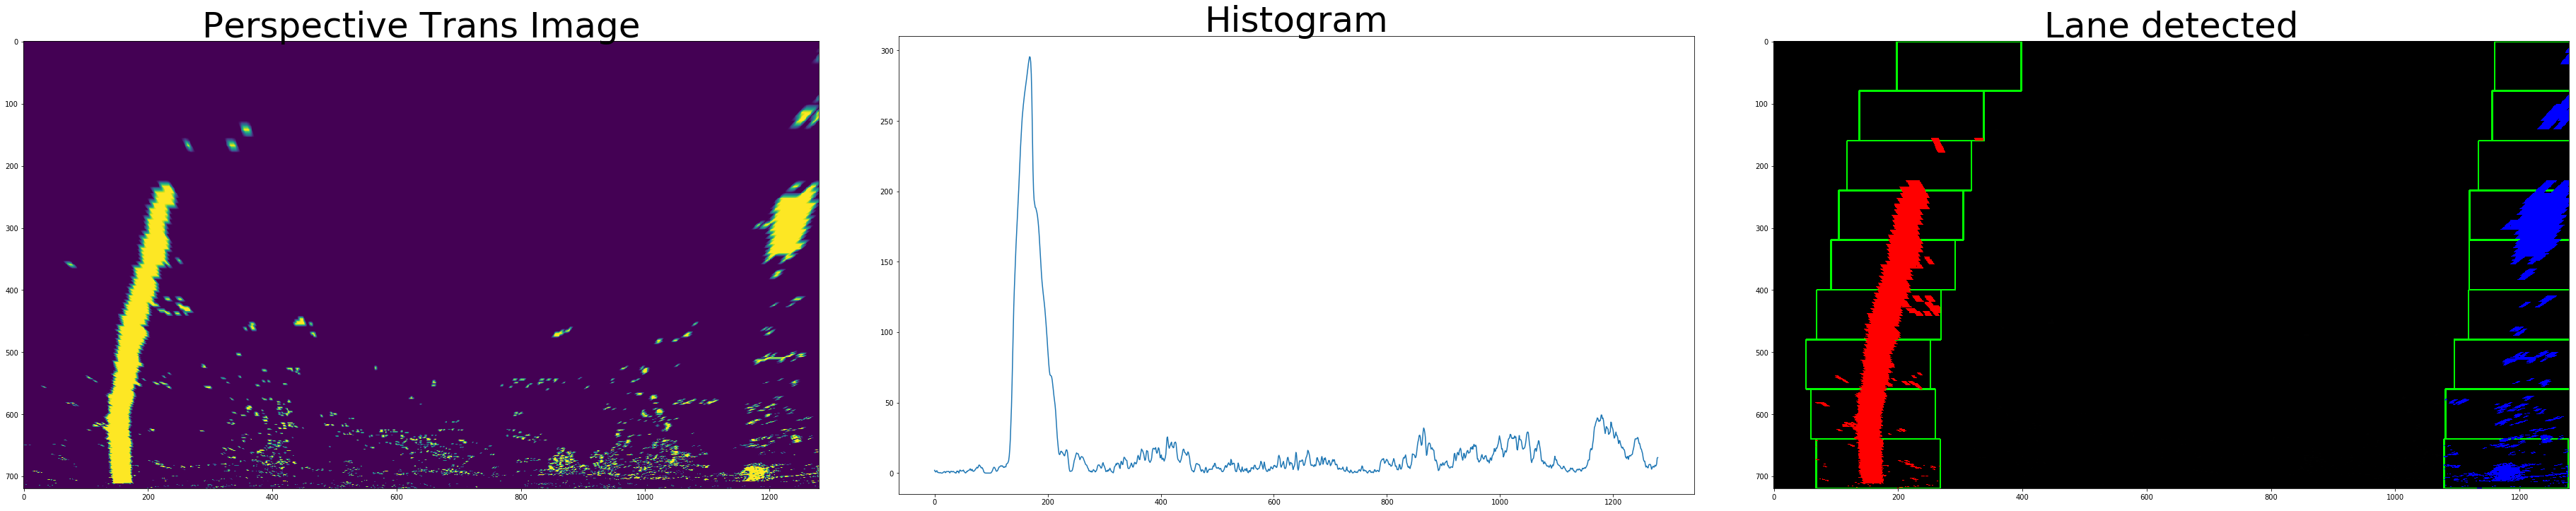

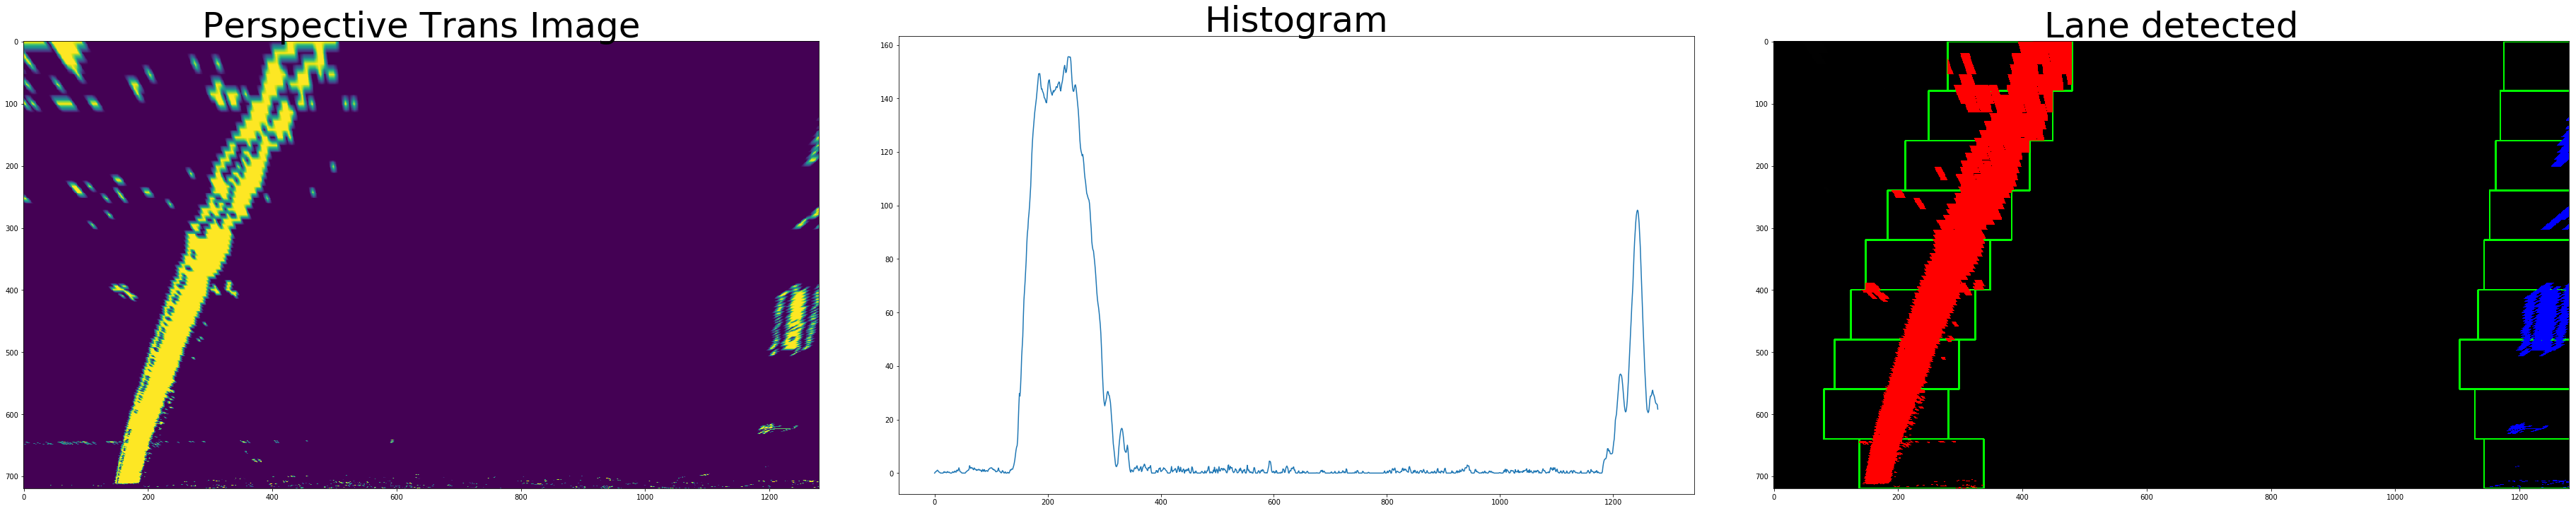

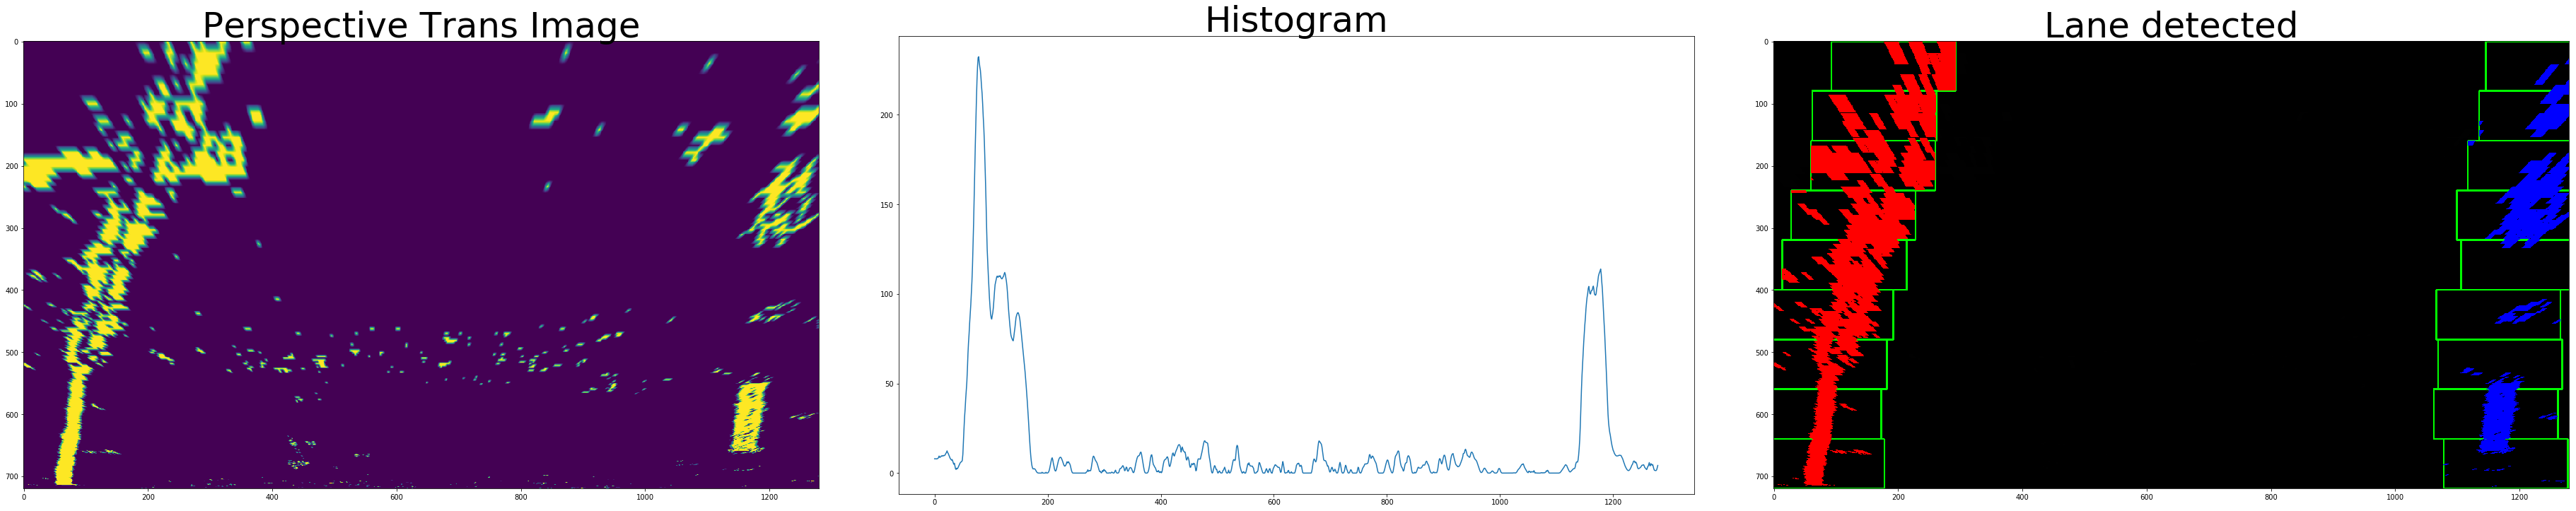

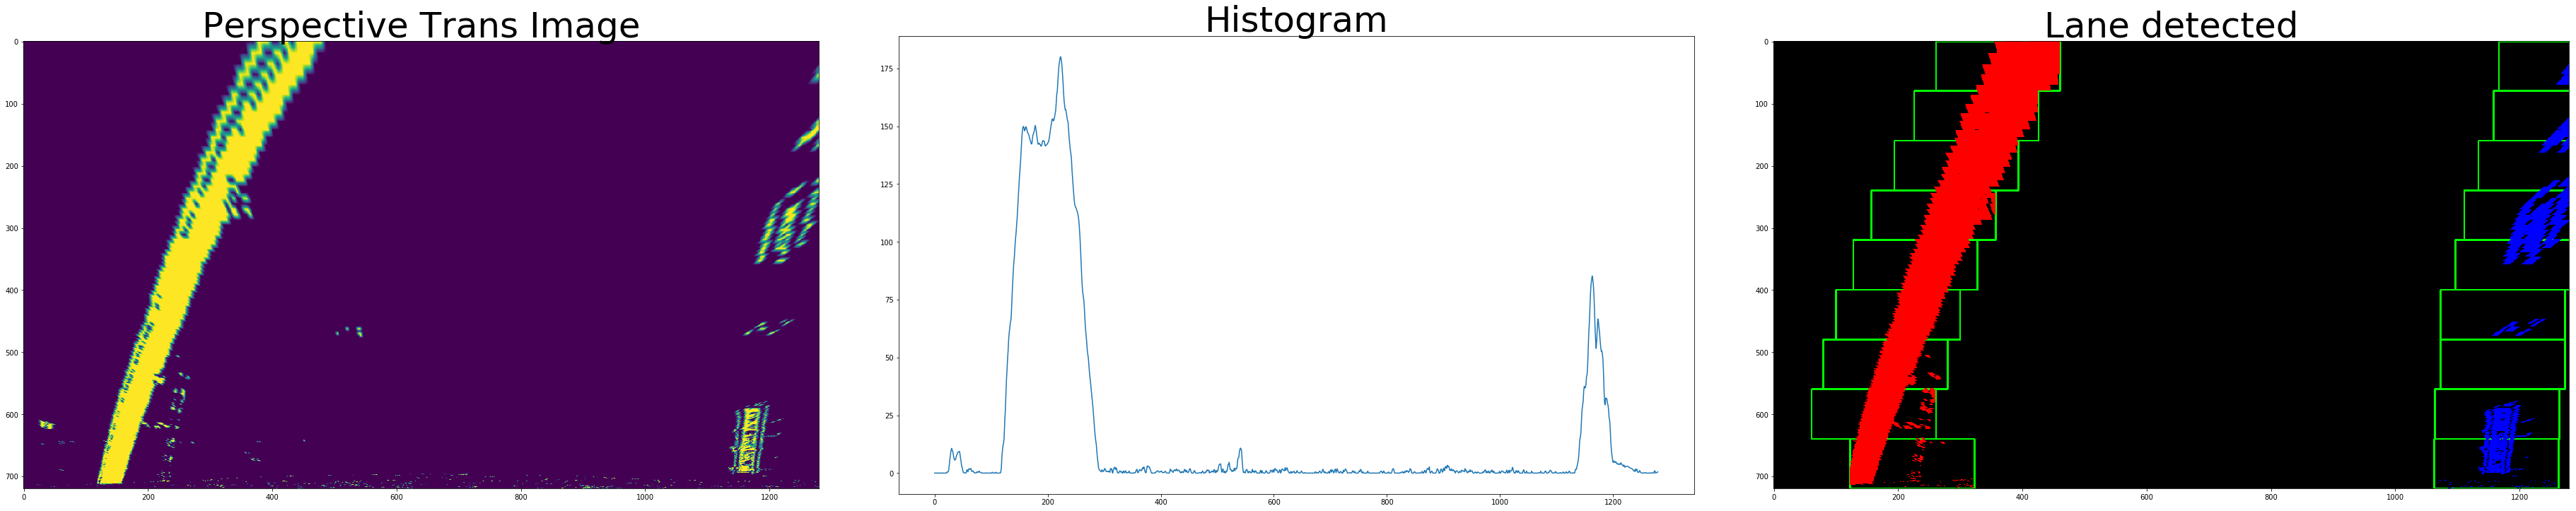

In [66]:
   
binary_detected_list, left_lines_detected, right_lines_detected = advlf_step_find_lane_lines(warped_images, plot_enabled=True)

In [67]:
# Step 6. Determine the vehicle position with respect to center.
def get_vehicle_position(img, left_line, right_line):
    
    diff = (img.shape[1]/2) - ((left_line.ally[-1]+right_line.ally[-1]) /2)
    return diff*left_line.xm_per_pix
    
    

In [68]:
# Step 8. Draw lines
def draw_result(undist, warped, left_line, right_line):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.ally, left_line.allx]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.ally, right_line.allx])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, np.linalg.inv(perp_matrices[ind]), (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result
    

In [69]:
def draw_final_result(undist, perp_trans, binary_detection, detected_left_line, detected_right_line):
    
    alpha = 0.5
    #overlay = np.zeros_like(undist).astype(np.uint8)
    overlay = undist.copy()
    
    # main image warping
    main_image = draw_result(undist, perp_trans, detected_left_line, detected_right_line)
    
    # top overlay
    cv2.rectangle(overlay, (0, 0), (undist.shape[1], 250),(0, 0, 0), -1)
    # apply  overlay
    main_image = cv2.addWeighted(overlay, alpha, main_image, 1-alpha, 0)
    
    # Adding subplot
    binary_window = np.zeros_like(undist)
    binary_window  = cv2.resize(binary_detection, (0,0), fx=0.3, fy=0.3)
    (height, width, _) = binary_window.shape  
    offset = 20    
    main_image[offset:offset + height, main_image.shape[1] - width - offset:main_image.shape[1] - offset, :] = 0
    main_image[offset:offset + height, main_image.shape[1] - width - offset:main_image.shape[1] - offset, :] = binary_window
    
    # Write curvature and position text
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1.5
    fontColor = (0,255,0)
    lineType = 5
    
    leftRadiusTextPosition = (50,80)
    rightRadiusTextPosition = (50,130)
    centerTextPosition = (50,200)
    
    leftRadiusText = "Curv Left: {0:.2f} m".format(detected_left_line.radius_of_curvature)
    rightRadiusText = "Curv Right : {0:.2f} m".format(detected_right_line.radius_of_curvature)
    vehicle_pos = get_vehicle_position(undist, detected_left_line, detected_right_line)
    
    suffix = 'to the Right' if vehicle_pos>=0 else 'to the Left'
        
    centerText = "Pos: {0:.2f}m".format(abs(vehicle_pos)) 
    centerText += ' '+suffix

    cv2.putText(main_image, leftRadiusText,  leftRadiusTextPosition, font, fontScale, fontColor, lineType)
    cv2.putText(main_image, rightRadiusText,  rightRadiusTextPosition, font, fontScale, fontColor, lineType)
    cv2.putText(main_image, centerText,  centerTextPosition, font, fontScale, fontColor, lineType)
    
    return main_image
    


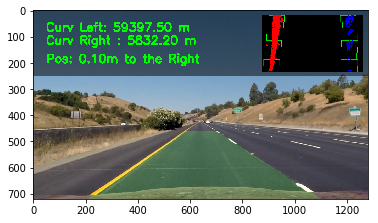

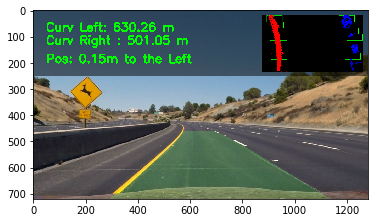

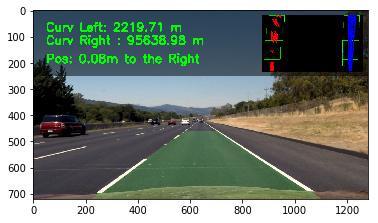

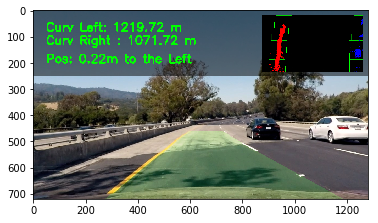

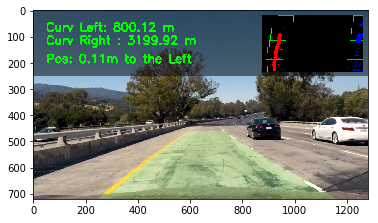

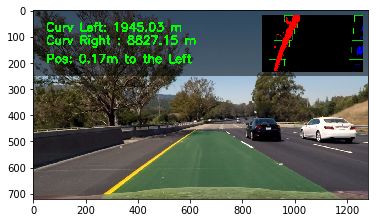

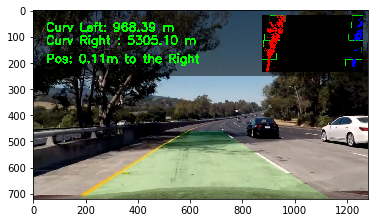

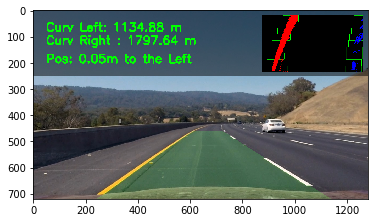

In [70]:
for ind, warped in enumerate(warped_images):
    
    undist = undistorted_images[ind]
    left_line = left_lines_detected[ind]
    right_line = right_lines_detected[ind]
    binary_detected = binary_detected_list[ind]
    result = draw_final_result(undist, warped, binary_detected, left_line, right_line)
    
    f, a = plt.subplots()
    a.imshow(result)
    plt.savefig(os.path.join('output_images','step6_result.png'))



In [71]:
class LaneFindingPipeline:
    
    def __init__(self, perp_roi, calib_folder='camera_cal'):
        # Step 1 - Camera Calibration
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate_camera(calib_folder, save_result=False)

        self.perp_roi = perp_roi
        self.is_setup = False
        self.prev_lines = [None, None]
        
    
    def pipeline_init_stages(self, img):
         # Step 2 - Distortion correction
        undist = advlf_undistort(img, mtx, dist)

        # Step 3 - Gradient Thresholding
        grad_thresh = advlf_gradient_threshold(undist)

        # Step 4 - Perspective Transform
        perp_trans, perp_matrix = advlf_perspective_transform(grad_thresh, perp_roi)
        
        return undist, grad_thresh, perp_trans, perp_matrix
    
    def setup_with_frame(self, img):
        
        undist, grad_thresh, perp_trans, perp_matrix = self.pipeline_init_stages(img)
        
        # Step 5 - Find lane pixels
        detected_left_line = Line()
        detected_right_line = Line()
        histogram, out_img = advlf_lane_boundaries_fit_polynomial(perp_trans, detected_left_line, 
                                                                  detected_right_line, perp_roi, 
                                                                  look_ahead_enabled=False)
        self.prev_lines[0] = detected_left_line
        self.prev_lines[1] = detected_right_line
        
        self.is_setup = True
        
        return draw_final_result(undist, perp_trans, out_img, detected_left_line, detected_right_line)
        


    def advanced_lane_finding_pipeline(self, img):
        
        if not self.is_setup:
            return setup_with_frame(img)
        
        undist = np.zeros_like(img)
        perp_trans = np.zeros_like(img)
        out_img = np.zeros_like(img)
        
        
        undist, grad_thresh, perp_trans, perp_matrix = self.pipeline_init_stages(img)
        
        # Step 5 - Find lane pixels
        detected_left_line = Line()
        detected_right_line = Line()
        
        detected_left_line.prev_fit = self.prev_lines[0].current_fit
        detected_right_line.prev_fit = self.prev_lines[1].current_fit

        histogram, out_img = advlf_lane_boundaries_fit_polynomial(perp_trans, detected_left_line, 
                                                                  detected_right_line, perp_roi, 
                                                                  look_ahead_enabled=True)
        # Step 6 - Warp back and print info
        #result = draw_result(undist, perp_trans, detected_left_line, detected_right_line)
        result = draw_final_result(undist, perp_trans, out_img, detected_left_line, detected_right_line)
        
        
        self.prev_lines[0] = detected_left_line
        self.prev_lines[1] = detected_right_line
        
        return result


In [72]:

def build_lane_finding_video(pipeline, subclip_end=None, video_file='project_video.mp4', 
                             output_folder='output_videos'):
    
    if subclip_end is not None:
        clipfile = VideoFileClip(video_file).subclip(0,subclip_end)
    else:
        clipfile = VideoFileClip(video_file)

    if not pipeline.is_setup:
        pipeline.setup_with_frame(clipfile.get_frame(0))

    result_clip = clipfile.fl_image(pipeline.advanced_lane_finding_pipeline) 
    
    output_video_path = os.path.join(output_folder, video_file)
    
    %time result_clip.write_videofile(output_video_path, audio=False)

In [73]:
# Pipeline Init

ROI_Y_MIN = 460
ROI_Y_MAX = 720

perp_roi = np.float32([(570,ROI_Y_MIN),(710, ROI_Y_MIN),(1160, ROI_Y_MAX),(200, ROI_Y_MAX)])

pipeline = LaneFindingPipeline(perp_roi)

In [ ]:
## Project video.mp4

video_file='project_video.mp4'
output_folder='output_videos'

build_lane_finding_video(pipeline, subclip_end=None, video_file=video_file, 
                         output_folder=output_folder)

res_video = os.path.join(output_folder, video_file)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(res_video))
    
    

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 60%|██████    | 762/1261 [04:08<02:45,  3.02it/s]